## 集成学习案例二 （蒸汽量预测）

### 背景介绍

火力发电的基本原理是：燃料在燃烧时加热水生成蒸汽，蒸汽压力推动汽轮机旋转，然后汽轮机带动发电机旋转，产生电能。在这一系列的能量转化中，影响发电效率的核心是锅炉的燃烧效率，即燃料燃烧加热水产生高温高压蒸汽。锅炉的燃烧效率的影响因素很多，包括锅炉的可调参数，如燃烧给量，一二次风，引风，返料风，给水水量；以及锅炉的工况，比如锅炉床温、床压，炉膛温度、压力，过热器的温度等。我们如何使用以上的信息，根据锅炉的工况，预测产生的蒸汽量，来为我国的工业届的产量预测贡献自己的一份力量呢？

所以，该案例是使用以上工业指标的特征，进行蒸汽量的预测问题。由于信息安全等原因，我们使用的是经脱敏后的锅炉传感器采集的数据（采集频率是分钟级别）。

### 数据信息
数据分成训练数据（train.txt）和测试数据（test.txt），其中字段”V0”-“V37”，这38个字段是作为特征变量，”target”作为目标变量。我们需要利用训练数据训练出模型，预测测试数据的目标变量。

### 评价指标
最终的评价指标为均方误差MSE，即：
$$Score = \frac{1}{n} \sum_1 ^n (y_i - y ^*)^2$$

### 导入package

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

# 模型
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

### 加载数据

In [2]:
data_train = pd.read_csv('train.txt',sep = '\t')
data_test = pd.read_csv('test.txt',sep = '\t')

In [3]:
#合并训练数据和测试数据
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)
#显示前5条数据
data_all.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V30,V31,V32,V33,V34,V35,V36,V37,target,oringin
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175,train
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676,train
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633,train
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206,train
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384,train


### 探索数据分布

这里因为是传感器的数据，即连续变量，所以使用 kdeplot(核密度估计图) 进行数据的初步分析，即EDA。
> 核密度估计：其实是对直方图的一个自然拓展，参考[什么是核密度估计？如何感性认识？](https://www.zhihu.com/question/27301358)

> EDA：探索性数据分析。（单变量，分析基本统计量、偏度峰度、分布、异常值、数据缺失；两个变量，分析相关性：线性、秩；整体上分析分类样本均衡、特征冗余、降维抽样分桶等）

> seaborn的文档 https://seaborn.pydata.org

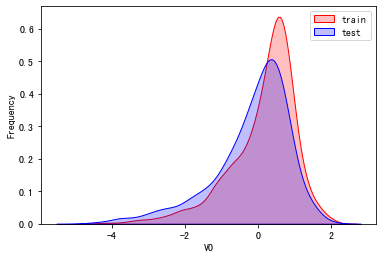

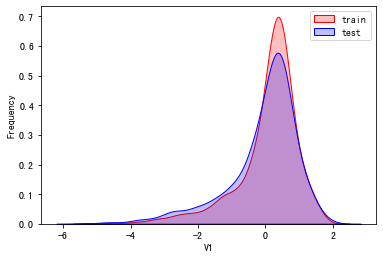

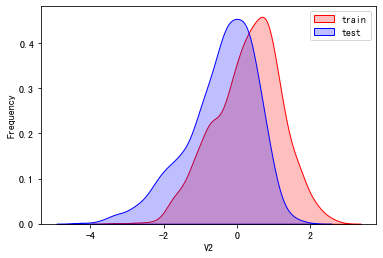

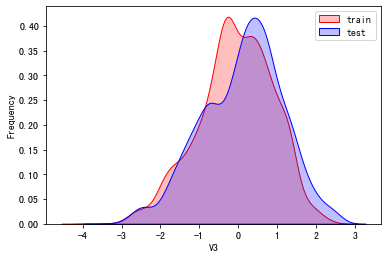

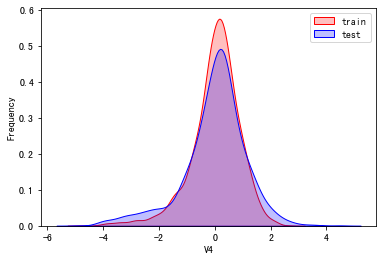

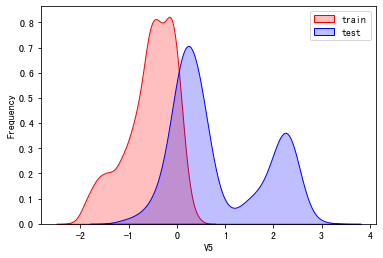

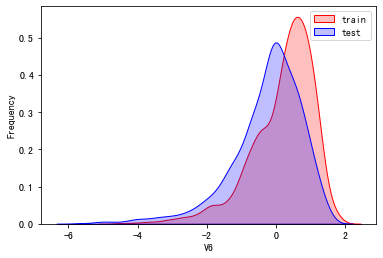

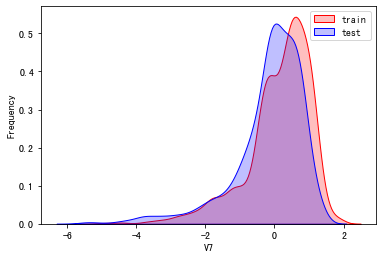

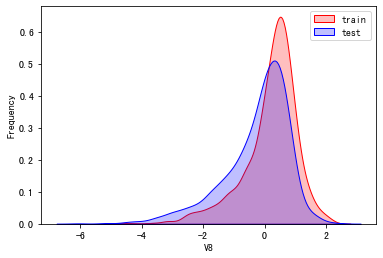

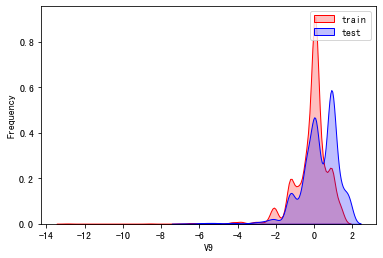

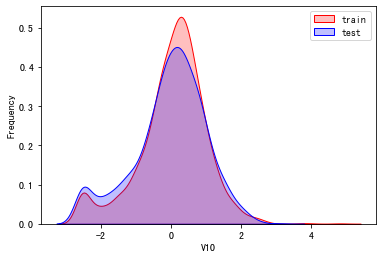

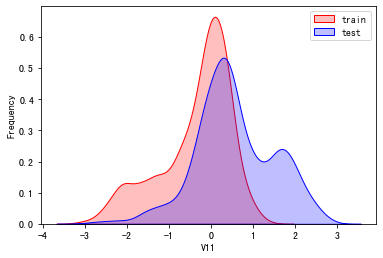

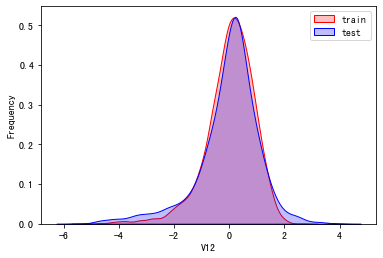

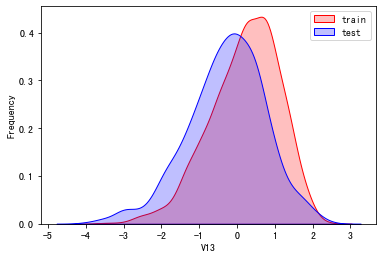

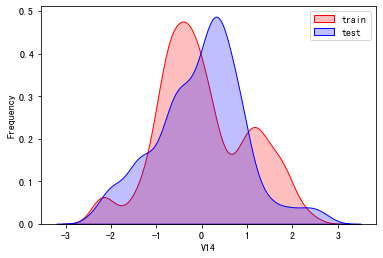

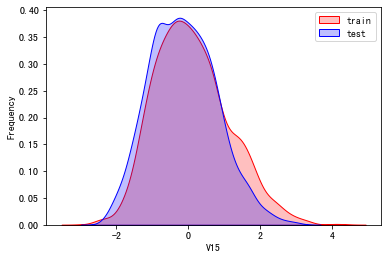

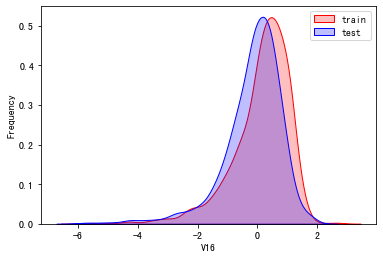

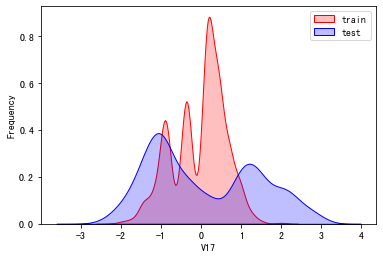

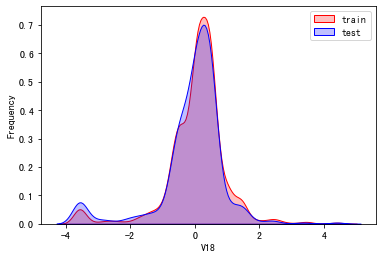

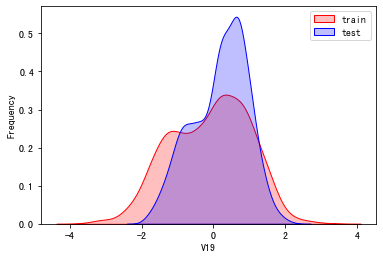

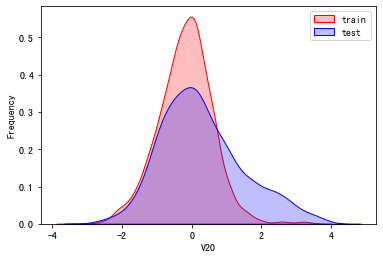

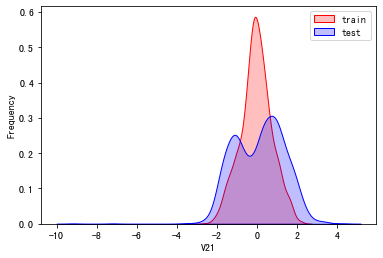

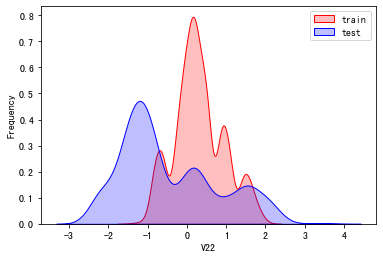

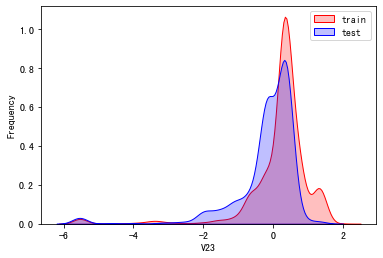

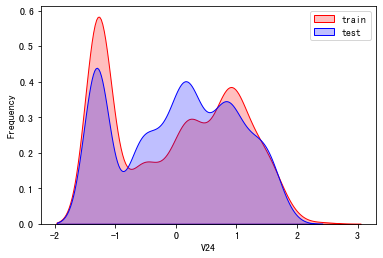

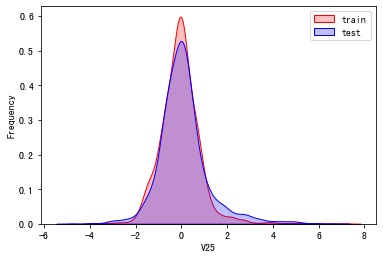

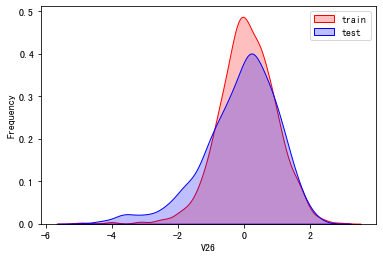

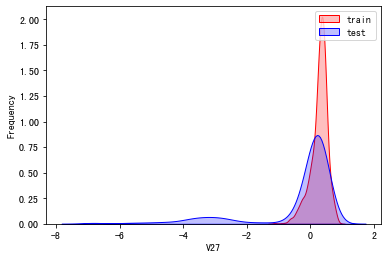

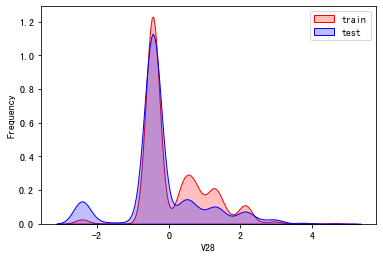

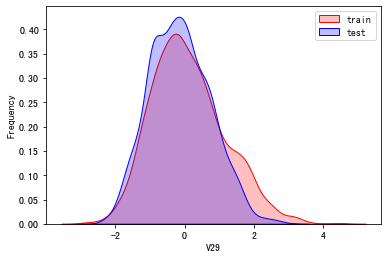

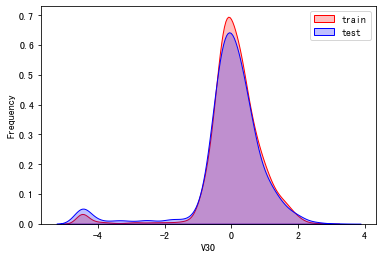

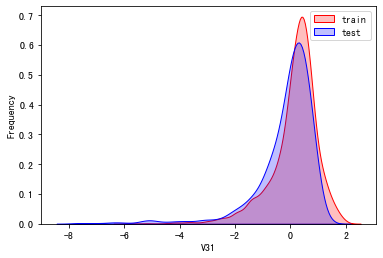

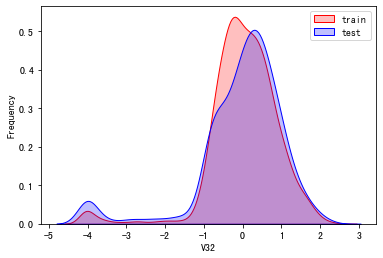

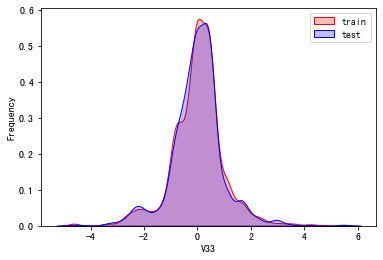

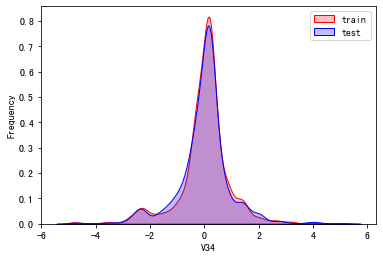

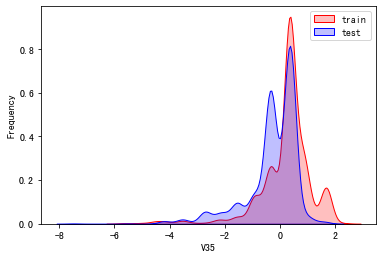

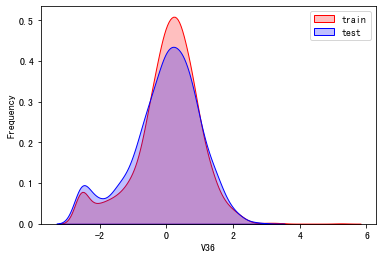

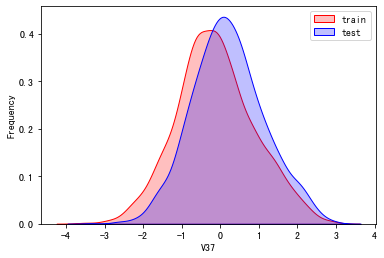

In [4]:
for column in data_all.columns[0:-2]:
    #核密度估计(kernel density estimation)是在概率论中用来估计未知的密度函数，属于非参数检验方法之一。通过核密度估计图可以比较直观的看出数据样本本身的分布特征。
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "train")], color="Red", shade = True)
    g = sns.kdeplot(data_all[column][(data_all["oringin"] == "test")], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

从以上的图中可以看出特征"V5","V9","V11","V17","V22","V28"中训练集数据分布和测试集数据分布不均，所以我们删除这些特征数据

In [5]:
data_all.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

查看特征之间的相关性（相关程度）

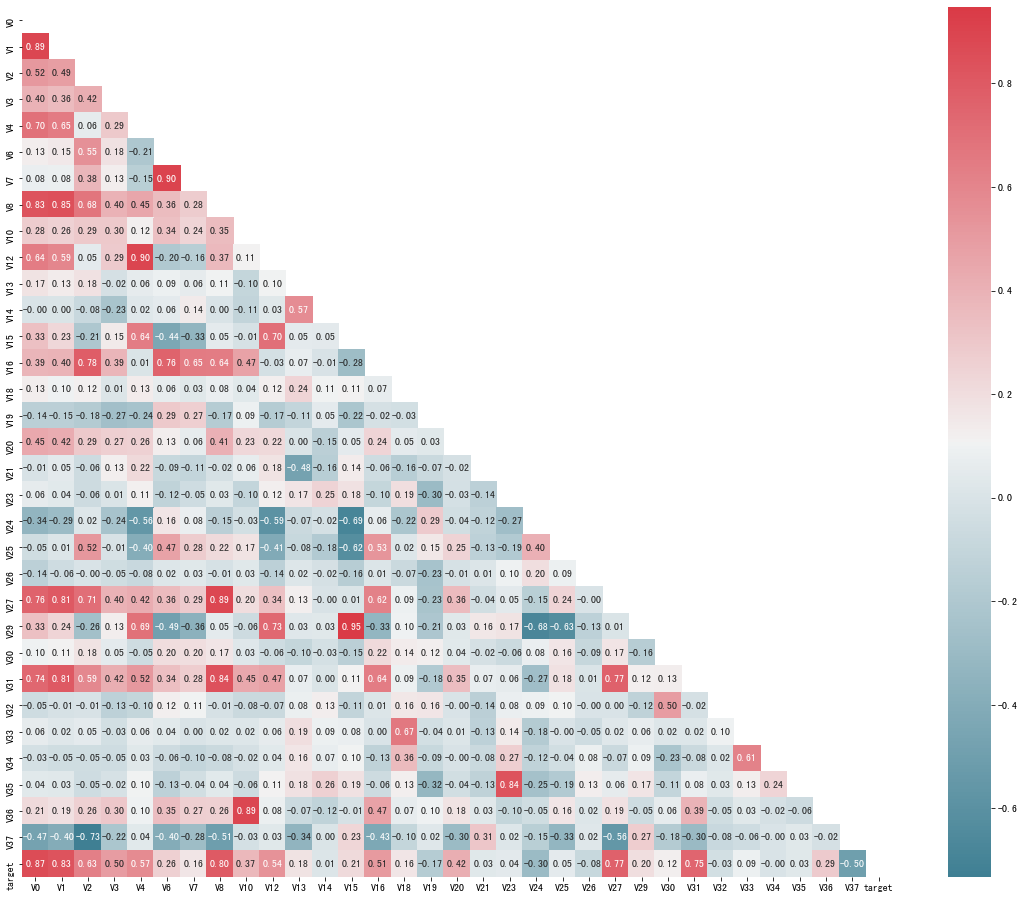

In [6]:
data_train1=data_all[data_all["oringin"]=="train"].drop("oringin",axis=1)
plt.figure(figsize=(20, 16))  # 指定绘图对象宽度和高度
colnm = data_train1.columns.tolist()  # 列表头
mcorr = data_train1[colnm].corr(method="spearman")  # 相关系数矩阵，即给出了任意两个变量之间的相关系数
mask = np.zeros_like(mcorr, dtype=np.bool)  # 构造与mcorr同维数矩阵 为bool型
mask[np.triu_indices_from(mask)] = True  # 角分线右侧为True
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 返回matplotlib colormap对象，调色板
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  # 热力图（看两两相似度）
plt.show()

进行降维操作，即将相关性的绝对值小于阈值的特征进行删除

In [7]:
threshold = 0.1
corr_matrix = data_train1.corr().abs()
drop_col=corr_matrix[corr_matrix["target"]<threshold].index
data_all.drop(drop_col,axis=1,inplace=True)

进行归一化操作

In [8]:
cols_numeric=list(data_all.columns)
cols_numeric.remove("oringin")
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())
scale_cols = [col for col in cols_numeric if col!='target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax,axis=0)
data_all[scale_cols].describe()

,V0,V1,V2,V3,V4,V6,V7,V8,V10,V12,...,V20,V23,V24,V27,V29,V30,V31,V35,V36,V37
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,...,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,0.694172,0.721357,0.602300,0.603139,0.523743,0.748823,0.745740,0.715607,0.348518,0.578507,...,0.456147,0.744438,0.356712,0.881401,0.388683,0.589459,0.792709,0.762873,0.332385,0.545795
std,0.144198,0.131443,0.140628,0.152462,0.106430,0.132560,0.132577,0.118105,0.134882,0.105088,...,0.134083,0.134085,0.265512,0.128221,0.133475,0.130786,0.102976,0.102037,0.127456,0.150356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.626676,0.679416,0.514414,0.503888,0.478182,0.683324,0.696938,0.664934,0.284327,0.532892,...,0.370475,0.719362,0.040616,0.888575,0.292445,0.550092,0.761816,0.727273,0.270584,0.445647
50%,0.729488,0.752497,0.617072,0.614270,0.535866,0.774125,0.771974,0.742884,0.366469,0.591635,...,0.447305,0.788817,0.381736,0.916015,0.375734,0.594428,0.815055,0.800020,0.347056,0.539317
75%,0.790195,0.799553,0.700464,0.710474,0.585036,0.842259,0.836405,0.790835,0.432965,0.641971,...,0.522660,0.792706,0.574728,0.932555,0.471837,0.650798,0.852229,0.800020,0.414861,0.643061
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 特征工程

绘图显示Box-Cox变换对数据分布影响，Box-Cox用于连续的响应变量不满足正态分布的情况。在进行Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。

对于quantitle-quantile(q-q)图，可参考： https://blog.csdn.net/u012193416/article/details/83210790

Box-Cox：https://baike.baidu.com/item/box-cox变换/10278422?fr=aladdin、
https://www.cnblogs.com/triple-y/p/11244798.html

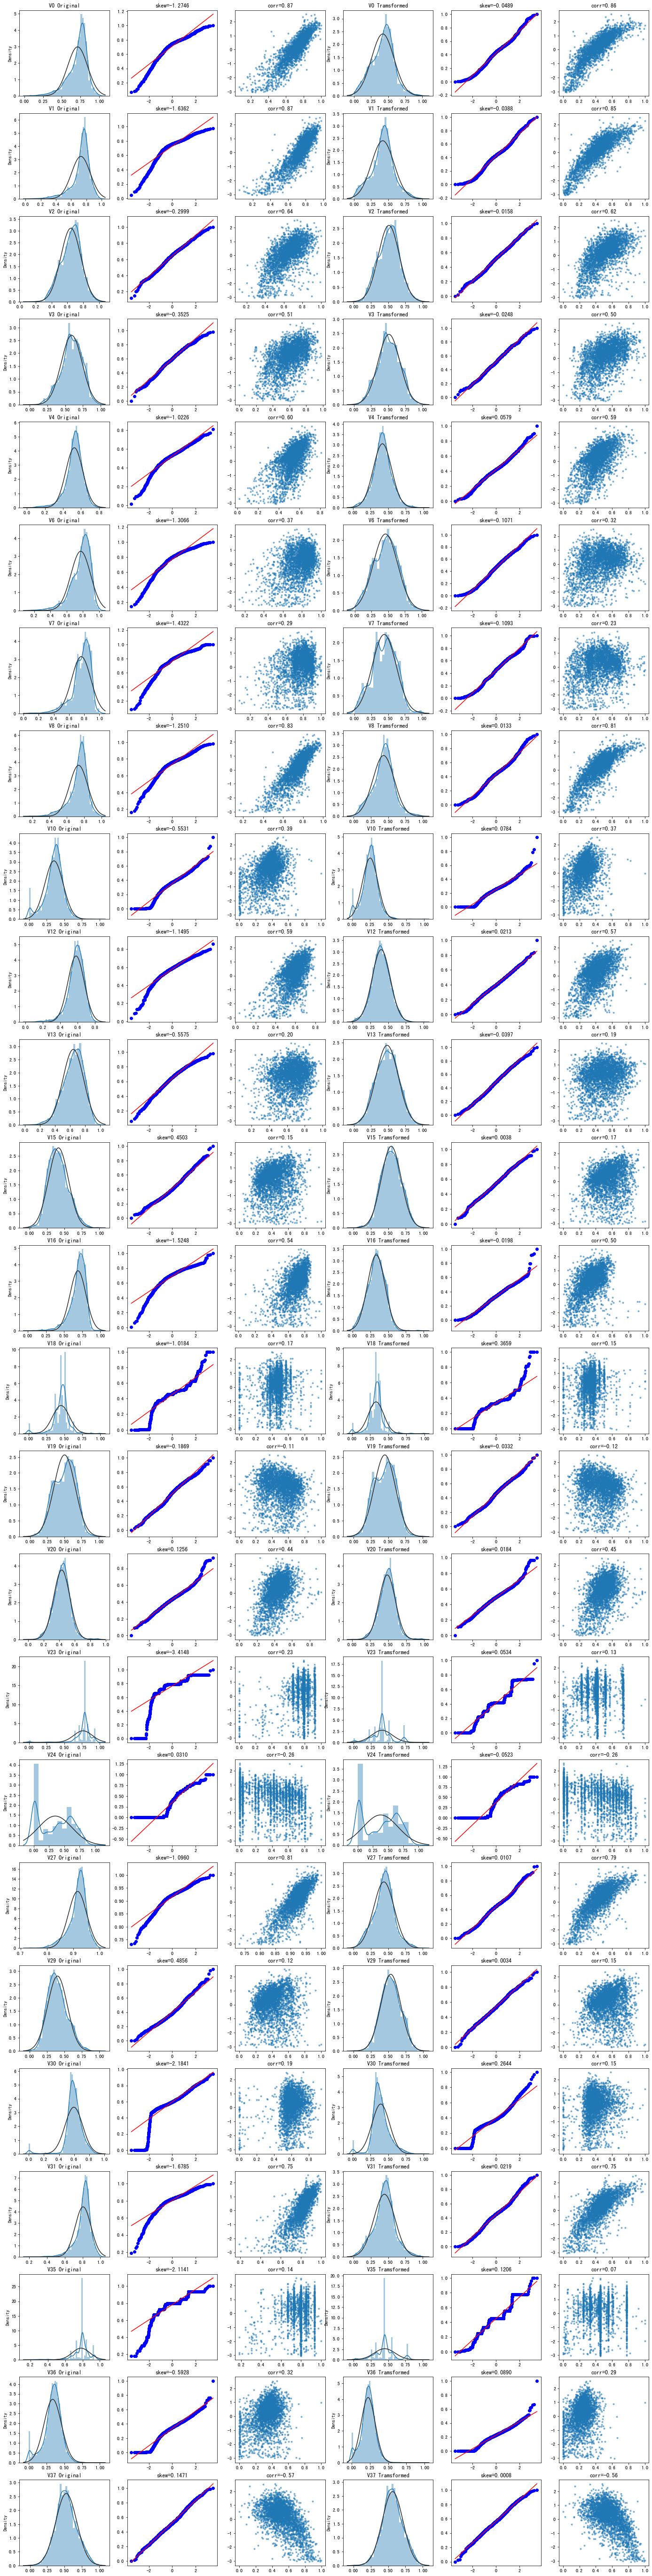

In [9]:
fcols = 6
frows = len(cols_numeric)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_numeric:
    if var!='target':
        dat = data_all[[var, 'target']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)  # 一种检验样本数据概率分布(例如正态分布)的方法。q-q 图是通过比较数据和正态分布的分位数是否相等来判断数据是不是符合正态分布
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


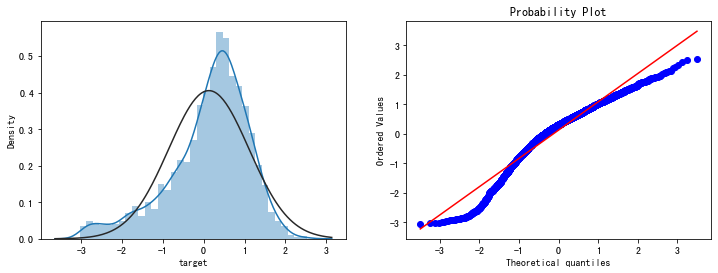

In [10]:
# 进行Box-Cox变换
cols_transform=data_all.columns[0:-2]
for col in cols_transform:   
    # transform column
    data_all.loc[:,col], _ = stats.boxcox(data_all.loc[:,col]+1)
print(data_all.target.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_all.target.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_all.target.dropna(), plot=plt)

使用对数变换target目标值提升特征数据的正太性
可参考：https://www.zhihu.com/question/22012482

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


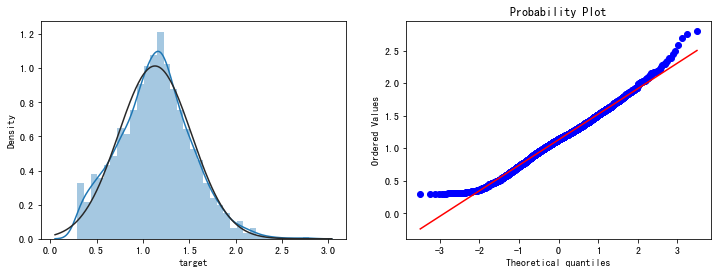

In [11]:
sp = data_train.target
data_train.target1 =np.power(1.5,sp)
print(data_train.target1.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_train.target1.dropna(),fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_train.target1.dropna(), plot=plt)

### 模型构建以及集成学习

构建训练集和测试集

In [27]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["oringin"]=="train"]
    df_train["label"]=data_train.target1
    # split SalePrice and features
    y = df_train.target
    X = df_train.drop(["oringin","target","label"],axis=1)
    X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.3,random_state=100)
    return X_train,X_valid,y_train,y_valid

# extract test data (without SalePrice)
def get_test_data():
    df_test = data_all[data_all["oringin"]=="test"].reset_index(drop=True)
    test_x, test_y = df_test.drop(["oringin","target"],axis=1), df_test.target
    return test_x, test_y

rmse、mse的评价函数

In [28]:
from sklearn.metrics import make_scorer
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    return np.sqrt(sum_sq/n)

def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False) 

#输入的score_func为记分函数时，该值为True（默认值）；输入函数为损失函数时，该值为False
mse_scorer = make_scorer(mse, greater_is_better=False)


寻找离群值，并删除

In [29]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    model.fit(X,y)
    y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print("mse=",mean_squared_error(y,y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    return outliers

R2= 0.8766692300840108
rmse= 0.349008677020025
mse= 0.12180705663526845
---------------------------------------
mean of residuals: 1.6062801207342691e-16
std of residuals: 0.34909505461744256
---------------------------------------
22 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 884, 2696, 2668, 1310, 1901, 1458, 2769, 2002, 2669, 1972]


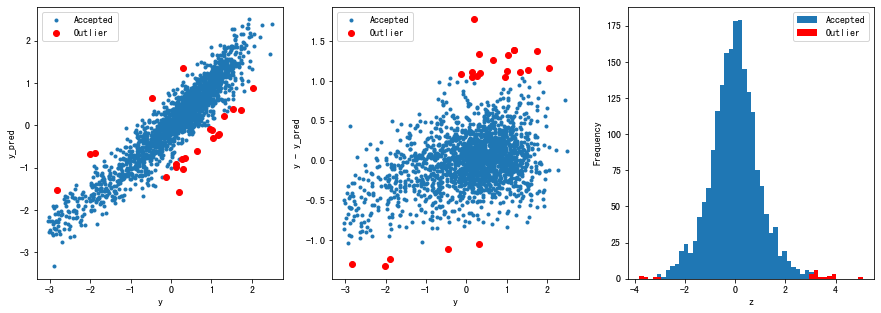

In [30]:
# get training data
X_train, X_valid,y_train,y_valid = get_training_data()
X_test, y_test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

进行模型的训练

In [31]:
def get_trainning_data_omitoutliers():
    #获取训练数据省略异常值
    y=y_t.copy()
    X=X_t.copy()
    return X,y

In [32]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # 获取数据
    if len(y)==0:
        X,y = get_trainning_data_omitoutliers()
        
    # 交叉验证
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # 网格搜索最佳参数
    if len(param_grid)>0:
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1, return_train_score=True)

        # 训练
        gsearch.fit(X,y)

        # 最好的模型
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # 获取交叉验证评价指标
        grid_results = pd.DataFrame(gsearch.cv_results_)
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # 没有网格搜索  
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # 合并数据
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # 预测
    y_pred = model.predict(X)
    
    # 模型性能的统计数据        
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('mse=',mse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # 残差分析与可视化
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    outliers = z[abs(z)>3].index
    
    return model, cv_score, grid_results

In [33]:
# 定义训练变量存储数据
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])
splits=5
repeats=5

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


----------------------
Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.8926884448727849
rmse= 0.3246640780758278
mse= 0.10540676359282722
cross_val: mean= 0.10894252883157667 , std= 0.00908981822372106


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    1.8s finished


Text(0, 0.5, 'score')

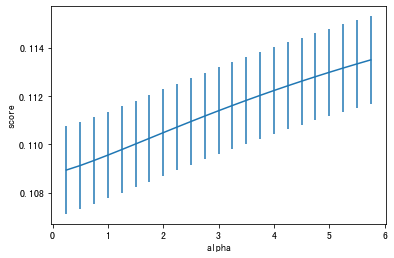

In [34]:
model = 'Ridge'  #可替换，见案例分析一的各种模型
opt_models[model] = Ridge() #可替换，见案例分析一的各种模型
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

In [35]:
# 预测函数
def model_predict(test_data,test_y=[]):
    i=0
    y_predict_total=np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model!="LinearSVR" and model!="KNeighbors":
            y_predict=opt_models[model].predict(test_data)
            y_predict_total+=y_predict
            i+=1
        if len(test_y)>0:
            print("{}_mse:".format(model),mean_squared_error(y_predict,test_y))
    y_predict_mean=np.round(y_predict_total/i,6)
    if len(test_y)>0:
        print("mean_mse:",mean_squared_error(y_predict_mean,test_y))
    else:
        y_predict_mean=pd.Series(y_predict_mean)
        y_predict_mean.to_csv('predict.txt',header = None,index = False)
        return y_predict_mean

#### 进行模型的预测以及结果的保存

In [40]:
y_test = y_test.fillna(0)
y_ = model_predict(X_test,y_test)

Ridge_mse: 1.576468907256756
mean_mse: 1.5764689232922602
